In [1]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import mplhep

import zfit

# mplhep.style.use("LHCb2")

import modplot
import numpy as np
import pandas as pd

import uproot


gpus = tf.config.experimental.list_physical_devices('GPU')

2024-02-22 04:09:08.165406: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 04:09:08.200611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 04:09:08.819972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/prozorov/install/miniconda3/envs/tf/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

# function for creating axes in the MOD plot style
def axes(ratio_plot=True, figsize=(4,4), gridspec_update=None,
         xlabel='', ylabel=r'Probability Density', ylabel_ratio='Ratio to\nTruth', units='', 
         xlim=(0,1), ylim=(0,1), ylim_ratio=(0.7,1.3),
         xticks=None, yticks=None, xtick_step=None, ytick_step=None, ytick_ratio_step=0.15,
         **kwargs):
    
    # gridspec options
    gridspec_kw = {'height_ratios': (3.5, 1) if ratio_plot else (1,), 'hspace': 0.0}
    if isinstance(gridspec_update, dict):
        gridspec_kw.update(gridspec_update)

    # get subplots
    nsubplots = 2 if ratio_plot else 1
    fig, axes = plt.subplots(nsubplots,  gridspec_kw=gridspec_kw, figsize=figsize)
    if nsubplots == 1:
        axes = [axes]
        
    # axes limits
    for ax in axes:
        ax.set_xlim(*xlim)
    axes[0].set_ylim(*ylim)
    if ratio_plot:
        axes[1].set_ylim(*ylim_ratio)
        
    # axes labels
    if units:
        xlabel = r'{} [{}]'.format(xlabel, units)
        ylabel = r'{} [{}{}]'.format(ylabel, units, r'$^{-1}$')
    axes[-1].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    if ratio_plot:
        axes[1].set_ylabel(ylabel_ratio, fontsize=8)
        
    # tick settings
    for ax in axes:
        ax.minorticks_on()
        ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')
    if ratio_plot:
        axes[0].tick_params(labelbottom=False)
        axes[1].tick_params(axis='y', labelsize=8)
    
    # tick locations and labels
    if xtick_step is not None:
        xticks_locs = [round(xlim[0] + i*xtick_step, 4) for i in range(1+math.floor((xlim[1]-xlim[0])/xtick_step))]
        axes[-1].set_xticks(xticks_locs)
        if xticks is None:
            axes[-1].set_xticklabels(list(map(str, xticks_locs)))
        else:
            axes[-1].set_xticklabels(xticks)
    if ytick_step is not None:
        yticks_locs = [round(ylim[0] + i*ytick_step, 4) for i in range(1+math.floor((ylim[1]-ylim[0])/ytick_step))]
        axes[0].set_yticks(yticks_locs)
        if yticks is None:
            axes[0].set_yticklabels(list(map(str, yticks_locs)))
        else:
            axes[0].set_yticklabels(yticks)
    if ytick_ratio_step is not None and ratio_plot:
        yticks = [round(ylim_ratio[0] + i*ytick_ratio_step, 4)
                  for i in range(1+round((ylim_ratio[1]-ylim_ratio[0])/ytick_ratio_step))][1:-1]
        axes[1].set_yticks(yticks)
        axes[1].set_yticklabels(list(map(str, yticks)))
    
    return fig, axes

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.13.1


# OmniFold


In [6]:
D0masMin = 1.75
D0masMax = 2.0
D0ptMin = 1.0

D0ExpCut = f"(D0mass > {D0masMin}) & (D0mass<{D0masMax}) & (D0_pT>{D0ptMin})"

centralityBins=[0,10]   # corresponds to 0 bin
#centralityBins=[10,40] # corresponds to 1 bin
#centralityBins=[40,80] # corresponds to 2 bin

features = [ "pt","z" , "lambda_1_1", "lambda_1_1half","lambda_1_2","lambda_1_3"]

doRealData = False


## ZFit 
Returns weights for centrality


In [7]:
from hepstats.splot import compute_sweights

obs = zfit.Space('D0mass', limits=(D0masMin, D0masMax))
mu = zfit.Parameter("mu", 1.865, 1.8, 1.92, step_size=0.0001)
sigma = zfit.Parameter("sigma", 0.02, 0.001, 0.3, step_size=0.0001)
lambd = zfit.Parameter("lambda", -3.0)
sig_yield = zfit.Parameter('sig_yield', 5300, 0, 100000,
                                step_size=10)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 25000, 0, 3e5, step_size=10)

def getSWeights(exp):
# model building, pdf creation
    signal_pdf  = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
    comb_bkg_pdf  = zfit.pdf.Exponential(lambd, obs=obs)

    data= zfit.Data.from_pandas(exp)

# Create the extended models
    extended_sig = signal_pdf.create_extended(sig_yield)
    extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
    model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

# plot the data
    data_mass = data["D0mass"].numpy()

# Builds the loss.
    data_sw = zfit.Data.from_numpy(obs=obs, array=data_mass)
    nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
    sigma.floating = False

# Minimizes the loss.
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    result_sw = minimizer.minimize(nll_sw)
   
    weights = compute_sweights(model, data_sw)
    return weights[sig_yield]


def getEfficiencyD0Yield(pT, centrality):
    # 2014 efficiency
    #                   0-10% ,  10-20% , 20-40% , 40-60% ,  60-80%
    efficiencies = [ [0.000622, 0.000740, 0.00088, 0.00108, 0.00140],         #for pT in range 0-0.5
                     [0.000717, 0.000717, 0.00110, 0.00143, 0.00160],         #for pT in range 0.5-1.0
                     [0.001025, 0.001300, 0.00195, 0.00304, 0.00289],         #for pT in range 1.0-1.5
                     [0.002248, 0.003014, 0.00411, 0.00610, 0.00528],         #for pT in range 1.5-2.0
                     [0.003794, 0.006104, 0.00738, 0.01072, 0.00997],         #for pT in range 2.0-2.5
                     [0.006107, 0.009671, 0.01006, 0.01606, 0.01447],         #for pT in range 2.5-3.0
                     [0.011249, 0.016457, 0.02087, 0.02565, 0.02482],         #for pT in range 3.0-4.0
                     [0.015830, 0.023905, 0.02984, 0.03553, 0.03663],         #for pT in range 4.0-5.0
                     [0.026520, 0.034723, 0.04134, 0.04656, 0.04032],         #for pT in range 5.0-6.0
                     [0.029904, 0.040095, 0.04888, 0.05334, 0.05080],         #for pT in range 6.0-8.0
                     [0.032680, 0.045229, 0.05514, 0.06017, 0.05685] ]        #for pT in range 8.0-30
    
    ptBins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 40]
    centBins = [0, 10, 20, 40, 60, 80]
    pT_range = 0
    centr_range = 0
    for i in range(len(ptBins)):
        if pT >= ptBins[i] and pT < ptBins[i+1]:
            pT_range = i
            break
    for i in range(len(centBins)):
        if  centrality >= centBins[i] and centrality < centBins[i+1]:
            centr_range = i
            break
    return efficiencies[pT_range][centr_range]

#     //https://inspirehep.net/literature/2051708
#     // https://journals.aps.org/prc/abstract/10.1103/PhysRevC.99.034908

# //D0 2014 efficiency                        0-10% ,     10-20% , 20-40% ,  40-60%  60-80%
#     const double efficiencies[11][5]={     {0.000622, 0.000740, 0.00088, 0.00108, 0.00140},         //pT = 0-0.5
#                                            {0.000717,0.000717, 0.00110, 0.00143, 0.00160},          //pT = 0.5-1.0
#                                            {0.001025, 0.001300, 0.00195, 0.00304, 0.00289},         //pT = 1.0-1.5
#                                            {0.002248, 0.003014, 0.00411, 0.00610, 0.00528},         //pT = 1.5-2.0
#                                            {0.003794,0.006104, 0.00738, 0.01072, 0.00997},          //pT = 2.0-2.5
#                                            {0.006107, 0.009671, 0.01006, 0.01606, 0.01447},         //pT = 2.5-3.0
#                                            {0.011249, 0.016457, 0.02087, 0.02565, 0.02482},         //pT = 3.0-4.0
#                                            {0.015830, 0.023905, 0.02984, 0.03553, 0.03663},         //pT = 4.0-5.0
#                                            {0.026520, 0.034723,   0.04134, 0.04656,0.04032},          //pT = 5.0-6.0
#                                            {0.029904, 0.040095,0.04888, 0.05334,0.05080},           //pT = 6.0-8.0
#                                            {0.032680,0.045229,    0.05514,0.06017,0.05685} };         //pT = 8.0-10.0

#     //https://drupal.star.bnl.gov/STAR/system/files/2018_1109_D0spectra_Note.pdf
#     //D0 2016 efficiency                        0-10%       10-20%  20-40%   40-60%      60-80%
#     const double efficiencies2016[11][5] = {  {0.000669, 0.000741, 0.000845, 0.000981, 0.001094},    //pT = 0-0.5
#                                               {0.000741, 0.000707, 0.001018, 0.001216, 0.001305},    //pT = 0.5-1.0
#                                               {0.001037, 0.001285, 0.001957, 0.002952, 0.002222},    //pT = 1.0-1.5
#                                               {0.002358, 0.002978, 0.004169, 0.005517, 0.004192},    //pT = 1.5-2.0
#                                               {0.004128, 0.006111, 0.007096, 0.009658, 0.008442},    //pT = 2.0-2.5
#                                               {0.006282, 0.009654, 0.010210, 0.014426, 0.012034},    //pT = 2.5-3.0
#                                               {0.012071, 0.016277, 0.020178, 0.024096, 0.020480},    //pT = 3.0-4.0
#                                               {0.018021, 0.023850, 0.028217, 0.033696, 0.029730},    //pT = 4.0-5.0
#                                               {0.026160, 0.034300, 0.042521, 0.047122, 0.033852},    //pT = 5.0-6.0
#                                               {0.029773, 0.039774, 0.047944, 0.051664, 0.038528},    //pT = 6.0-8.0
#                                               {0.032934, 0.044408, 0.054539, 0.058225, 0.043018} }; //pT = 8.0-10.0
# }


2024-02-22 04:09:12.236941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 04:09:12.237037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 04:09:12.237059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 04:09:13.471373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 04:09:13.471401: I tensorflow/core/co

In [8]:
# with uproot.open("/home/prozorov/dev/star/unfold/JetFinderEfficiency.root") as file:
#     hist=file["JetFinderEfficiency"] #2d histogram
#     eff=hist.to_numpy()

#     values = eff[0]
#     ptBinsEdges = eff[1]

#     print(ptBinsEdges)

#     print(values)
ptBinsEdges =( 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 18, 30)
# centrality : 0-10%,     10-40%,    40-80%
values =  [ [0.8040493,  0.83887934, 0.91436481],
            [0.83531431, 0.87066498, 0.93592894],
            [0.86378964, 0.89502397, 0.94950428],
            [0.8858829,  0.91200534, 0.95879075],
            [0.90171456, 0.92392761, 0.96557282],
            [0.91389318, 0.93324831, 0.97033296],
            [0.92173535, 0.94047693, 0.97348525],
            [0.92743685, 0.94662845, 0.97777634],
            [0.93525452, 0.94907014, 0.97975429],
            [0.94756974, 0.95762499, 0.98211105],
            [0.95040946, 0.96266307, 0.98382422],
            [0.96602388, 0.96608892, 0.98780008],
            [0.96862745, 0.96307934, 0.99102773]
]

def getSimJetFinderEfficiency(pt, centralityBin): #centralityBin = 0 (0-10%) , 1(10-40%) or 2(40-80%)
    ptBin = np.digitize(pt, ptBinsEdges)-1
    if (ptBin<0):
        ptBin=0
    elif (ptBin>=len(values)):
        ptBin=len(values)-1
    return values[ptBin][centralityBin]


## Setup the Datasets

In [9]:

centralityCuts = ["(Centrality >= {}) & (Centrality < {})".format(centralityBins[i], centralityBins[i+1]) for i in range(len(centralityBins)-1)]
nEvents=100000

# make centrality dependent analysis
print("Processing centrality bin: ", centralityCuts[0])

embedding_tree = uproot.open("/home/prozorov/dev/star/output_jets.root:Jets")
exp_tree       = uproot.open("/home/prozorov/dev/star/OUTPUT_2014_20012024.root:Jets")

exp = exp_tree.arrays(["D0_pT","D0mass", "centrality", "centr_weight", "jet_pt_corr",
                       "z", "lambda_1_1","lambda_1_1half","lambda_1_2","lambda_1_3"], 
                       cut=D0ExpCut, library='pd')
#apply centrality cut
mapCentrality = {0:70, 1:60, 2:50, 3:40, 4:30, 5:20, 6:10, 7:5, 8:0}
exp["centrality"]  = exp["centrality"].apply(lambda x: mapCentrality[x])
jetFilter =(exp["centrality"]>=centralityBins[0]) & (exp["centrality"]<centralityBins[1])
exp = exp.loc[jetFilter]
expcopy = exp.copy()
exp["SWeight"] = getSWeights(expcopy)

print(exp.head())
exp["Eff"] = exp.apply(lambda row: getEfficiencyD0Yield(row["D0_pT"], row["centrality"]), axis=1)
print(exp.head())
exp["Weight"] = exp["SWeight"]*exp["Eff"]*exp["centr_weight"]
print(exp.head())

exp.drop(columns=["SWeight", "Eff", "centr_weight", "D0_pT","D0mass", "centrality"], inplace=True)
exp.rename(columns={"jet_pt_corr": "pt"}, inplace=True)


columns = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3",
            "RecoJetPt","RecoJetD0Z", "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","Centrality","Weight"]
sim_mc_reco= embedding_tree.arrays(columns, cut=centralityCuts[0] + "& (RecoJetNConst!=0)", library="pd", entry_stop=nEvents)

centralityBinMap = {0:0, 10:1, 40:2}
sim_mc_reco["Weight"] = sim_mc_reco["McJetPt"].apply( lambda pt: getSimJetFinderEfficiency(pt, centralityBinMap[centralityBins[0]]))

print("Data events: ", len(exp))
print("MC events: ", len(sim_mc_reco))

print(exp.head())


Processing centrality bin:  (Centrality >= 0) & (Centrality < 10)
       D0_pT    D0mass  centrality  centr_weight  jet_pt_corr         z  \
3   1.325599  1.868544           0      0.835513    29.197884  0.045710   
4   1.325599  1.813106           0      0.835513    29.589823  0.045153   
8   2.083829  1.948493           5      0.849466    17.570477  0.119544   
13  3.717934  1.866389           0      0.823147    20.870733  0.178547   
17  2.376184  1.978131           0      0.777055    24.898172  0.096430   

    lambda_1_1  lambda_1_1half  lambda_1_2  lambda_1_3   SWeight  
3     0.430175        0.348704    0.291515    0.217739  1.248423  
4     0.424477        0.344085    0.287653    0.214855 -0.302563  
8     1.011170        0.845190    0.721362    0.552146 -0.454587  
13    0.533946        0.400335    0.308472    0.196662  1.252240  
17    0.790815        0.671502    0.580718    0.455745 -0.455726  
       D0_pT    D0mass  centrality  centr_weight  jet_pt_corr         z  \
3   1.

In [10]:
print(sim_mc_reco["Weight"].head(20))

13     0.885883
16     0.913893
39     0.863790
44     0.913893
45     0.835314
47     0.901715
51     0.835314
82     0.804049
94     0.804049
95     0.863790
96     0.927437
97     0.901715
100    0.863790
124    0.804049
126    0.913893
128    0.921735
129    0.835314
140    0.863790
148    0.835314
164    0.835314
Name: Weight, dtype: float64


In [11]:
genMcJets = sim_mc_reco.iloc[:,0:6]
genMcJets.rename(columns={"McJetPt": "pt", "McJetD0Z": "z",  "McJetLambda_1_1": "lambda_1_1", "McJetLambda_1_1half": "lambda_1_1half", "McJetLambda_1_2": "lambda_1_2", "McJetLambda_1_3": "lambda_1_3"}, inplace=True)
genMcJets["Weight"] = sim_mc_reco["Weight"]

recoMcJets = sim_mc_reco.iloc[:,6:12]
recoMcJets.rename(columns={"RecoJetPt": "pt", "RecoJetD0Z": "z" , "RecoJetLambda_1_1": "lambda_1_1", "RecoJetLambda_1_1half": "lambda_1_1half", "RecoJetLambda_1_2": "lambda_1_2", "RecoJetLambda_1_3": "lambda_1_3"}, inplace=True)
recoMcJets["Weight"] = sim_mc_reco["Weight"] 

assert genMcJets.shape == recoMcJets.shape
assert genMcJets.shape == recoMcJets.shape


print("genMcJets: ", genMcJets.head(20))
print("recoMcJets: ", recoMcJets.head(20))

## Closure test on embedding
trainGen, testGen, trainReco, testReco = train_test_split(genMcJets, recoMcJets, test_size=0.2)

## Train on MC, test on data 
# trainGen = genMcJets
# trainReco = recoMcJets
# testReco = exp




genMcJets:             pt         z    lambda_1_1  lambda_1_1half    lambda_1_2  \
13   4.332043  0.942510  3.377420e-02    7.194136e-03  2.089331e-03   
16   6.787934  0.890960  8.479527e-02    2.258711e-02  7.406180e-03   
39   3.019047  1.000000  3.066259e-17    1.073849e-25  3.760778e-34   
44   6.158446  0.690154  3.199627e-01    1.346572e-01  6.290882e-02   
45   2.194314  0.775095  1.120121e-01    2.711296e-02  7.142981e-03   
47   5.860472  0.247135  3.208839e-01    1.462017e-01  6.857074e-02   
51   2.443995  0.512774  4.091412e-01    1.652737e-01  6.680603e-02   
82   1.289757  0.834505  2.599400e-01    1.023278e-01  4.574445e-02   
94   1.351508  1.000000  8.233160e-18    1.494101e-26  2.711397e-35   
95   3.620003  0.929971  3.221424e-02    6.192002e-03  1.575417e-03   
96   8.257239  0.595294  2.438712e-01    9.174751e-02  3.913308e-02   
97   5.518092  0.909288  1.105838e-02    7.712862e-04  5.379472e-05   
100  3.120220  0.525854  5.358506e-01    2.484886e-01  1.155148e-

In [12]:
exp.head()

,pt,z,lambda_1_1,lambda_1_1half,lambda_1_2,lambda_1_3,Weight
3,29.197884,0.045710,0.430175,0.348704,0.291515,0.217739,0.001069
4,29.589823,0.045153,0.424477,0.344085,0.287653,0.214855,-0.000259
8,17.570477,0.119544,1.011170,0.845190,0.721362,0.552146,-0.001465
13,20.870733,0.178547,0.533946,0.400335,0.308472,0.196662,0.011595
17,24.898172,0.096430,0.790815,0.671502,0.580718,0.455745,-0.001344


## Unfold Data

In [13]:
iterations = 4

In [20]:
# Processed MC reco data for training
X_det = np.concatenate((trainReco[features][features][features][features], testReco[features]))
# labels0 = {0}, labels_unknown = {1} 
Y_det = np.concatenate((np.zeros(trainReco.shape[0]), np.ones(testReco.shape[0])))

# Processed MC truth data data for training
X_gen = np.concatenate((trainGen[features], trainGen[features]))
Y_gen = np.concatenate((np.zeros(trainGen.shape[0]), np.ones(trainGen.shape[0])))

# Push and pull weights in unfolding
weights = np.empty(shape=(iterations, 2, len(trainReco)))
weights_true= np.empty(shape=(iterations, 2, len(trainGen)))
# shape = (#iteration, #step, #event)

# Normalization layer for input variables
normalizerLayer = tf.keras.layers.Normalization()
normalizerLayer.adapt(trainReco[features])

# tensorflow DNN model 
inputs = Input((len(features),)) #  vector of number of features as input
normalized_layer = normalizerLayer(inputs)
# three hidden layers 
hidden_layer_1 = Dense(50, activation='relu')(normalized_layer)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_2)
model = Model(inputs=inputs, outputs=outputs)

# Early stopping criteria to avoid overtraining
earlystopping = EarlyStopping(patience=2,
                              verbose=1,
                              restore_best_weights=True)



In [22]:
print ("X_det: ", X_det.shape)
print ("Y_det: ", Y_det.shape)

print ("X_gen: ", X_gen.shape)
print ("Y_gen: ", Y_gen.shape)


X_det:  (14853, 6)
Y_det:  (14853,)
X_gen:  (23764, 6)
Y_gen:  (23764,)


In [23]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=2000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights,nan=1.)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [24]:
trainWts = trainGen["Weight"]
trainWts = trainWts/trainWts.mean()
# print("Sum of training weights: ", trainWts.sum())

testWts = testReco["Weight"]
testWts = testWts/testWts.mean()
# print("Sum of testing weights: ", testWts.sum())

# # reweight the sim and data to have the same total weight to begin with
ndata, nsim = np.count_nonzero(Y_det), np.count_nonzero(Y_det==0)
# winit = ndata/nsim*trainWts


wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

# # Push and pull weights in unfolding
# # initial iterative weights are the nominal weight
weights_pull = winit
weights_push = winit
w_data = wdata



print(np.sum(winit), np.sum(w_data))
print(np.sum(testWts), np.sum(trainWts))


2971.0000000000014 2971.0
2971.0 11881.999999999998


In [25]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    # weights_push = weights from previous interation
    # w_data is the "real" data
    weights_1 = np.concatenate((weights_push, w_data))

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        X_det, Y_det, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    # Classification at reco level
    model.fit(X_train_1, 
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=100,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    # reco events weights after reco level reweight
    weights_pull = weights_push * reweight(trainReco[features])
    
    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    # Training for events that don't pass reco
    # "Signal" is true MC events after reco level reweight, "background" is the un-weighted true MC events
    # X_detb = np.concatenate((trainReco[features],trainReco[features]))
    # Y_detb = np.concatenate([np.ones(len(trainReco)),np.zeros(len(trainReco))])
    # weights_1b = np.concatenate((weights_pull,trainGen["Weight"]))
    
    # X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
    #     X_detb, Y_detb, weights_1b)    
    
    # model.compile(loss='binary_crossentropy',
    #               optimizer='Adam',
    #               metrics=['accuracy'])
    # model.fit(X_train_1b,
    #           Y_train_1b,
    #           sample_weight=w_train_1b,
    #           epochs=200,
    #           batch_size=100,
    #           validation_data=(X_test_1b, Y_test_1b, w_test_1b),
    #           callbacks=[earlystopping],
    #           verbose=1)
    
    # truth events weights after reco level reweight
    average_vals = trainGen["Weight"]#*reweight(trainGen[features])

    ###
    
    weights[i, :1, :] = weights_pull
    weights_true[i,:1,:] = average_vals

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    # "Signal" is MC truth events after reco level reweight, "background" is the un-weighted true MC events
    weights_2 = np.concatenate((trainGen["Weight"], average_vals))

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        X_gen, Y_gen, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=100,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    # weights after truth level reweight
    weights_true[i, 1:2, :] = reweight(trainGen[features])*trainGen["Weight"]
    weights_push = reweight(trainReco[features])*trainGen["Weight"]
    ### 
    
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200


2024-02-22 04:14:08.358242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-22 04:14:08.365083: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcc1d5b8ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-22 04:14:08.365118: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-02-22 04:14:08.370137: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-22 04:14:08.383051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-02-22 04:14:08.469820: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-22 

112/112 [==============================] - 3s 7ms/step - loss: 0.2778 - accuracy: 0.3531 - val_loss: 0.2769 - val_accuracy: 0.4402
Epoch 2/200
112/112 [==============================] - 1s 6ms/step - loss: 0.2776 - accuracy: 0.4817 - val_loss: 0.2772 - val_accuracy: 0.5382
Epoch 3/200
112/112 [==============================] - 1s 5ms/step - loss: 0.2776 - accuracy: 0.5738 - val_loss: 0.2775 - val_accuracy: 0.3368
Epoch 3: early stopping
6/6 [==============================] - 0s 2ms/step
Epoch 1/200
179/179 [==============================] - 2s 6ms/step - loss: 0.3098 - accuracy: 0.4990 - val_loss: 0.2972 - val_accuracy: 0.5031
Epoch 2/200
179/179 [==============================] - 1s 5ms/step - loss: 0.2971 - accuracy: 0.4990 - val_loss: 0.2974 - val_accuracy: 0.5031
Epoch 3/200
179/179 [==============================] - 1s 5ms/step - loss: 0.2970 - accuracy: 0.4990 - val_loss: 0.2967 - val_accuracy: 0.5031
Epoch 4/200
179/179 [==============================] - 1s 5ms/step - loss: 0.29

In [26]:
weights

array([[[0.25880738, 0.24881388, 0.25545927, ..., 0.24946304,
         0.24263402, 0.24743014],
        [0.29001978, 0.26995326, 0.27866018, ..., 0.26134309,
         0.25972285, 0.29324113]],

       [[0.26053533, 0.24276862, 0.25707435, ..., 0.23431152,
         0.22108721, 0.26512345],
        [0.23760257, 0.22794994, 0.2442272 , ..., 0.22209909,
         0.22371022, 0.24515075]],

       [[0.26645525, 0.24294624, 0.24459526, ..., 0.23568915,
         0.21812106, 0.26328302],
        [0.25725688, 0.23981362, 0.22615541, ..., 0.23335065,
         0.21252351, 0.25892436]],

       [[0.26000928, 0.24946908, 0.26181353, ..., 0.24109537,
         0.2302421 , 0.27247625],
        [0.27452301, 0.26507813, 0.25962403, ..., 0.25651577,
         0.23475702, 0.28940514]]])

/tmp/ipykernel_168352/2559933602.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


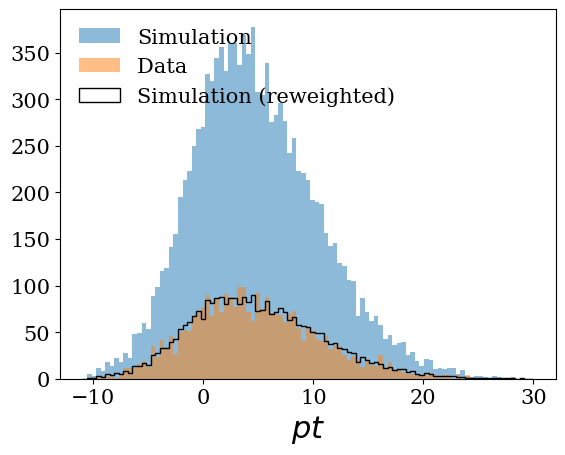

In [27]:
wdata = weights[iterations-1,0,:] #weights after last iteration for pull after step 1
bins = np.linspace(-11, 30, 100)

fig =plt.gcf()
ax = plt.gca()
ax.set_xlabel('$pt$')
ax.hist(trainReco["pt"], bins=bins, **plot_style_2, label='Simulation')
ax.hist(testReco["pt"], bins=bins, **plot_style_2, label='Data ')
ax.hist(trainReco["pt"], bins=bins, histtype="step", label='Simulation (reweighted)',color="black",weights=wdata)
legend = ax.legend(
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

Done with pt
Done with z
Done with lambda_1_1
Done with lambda_1_1half
Done with lambda_1_2
Done with lambda_1_3


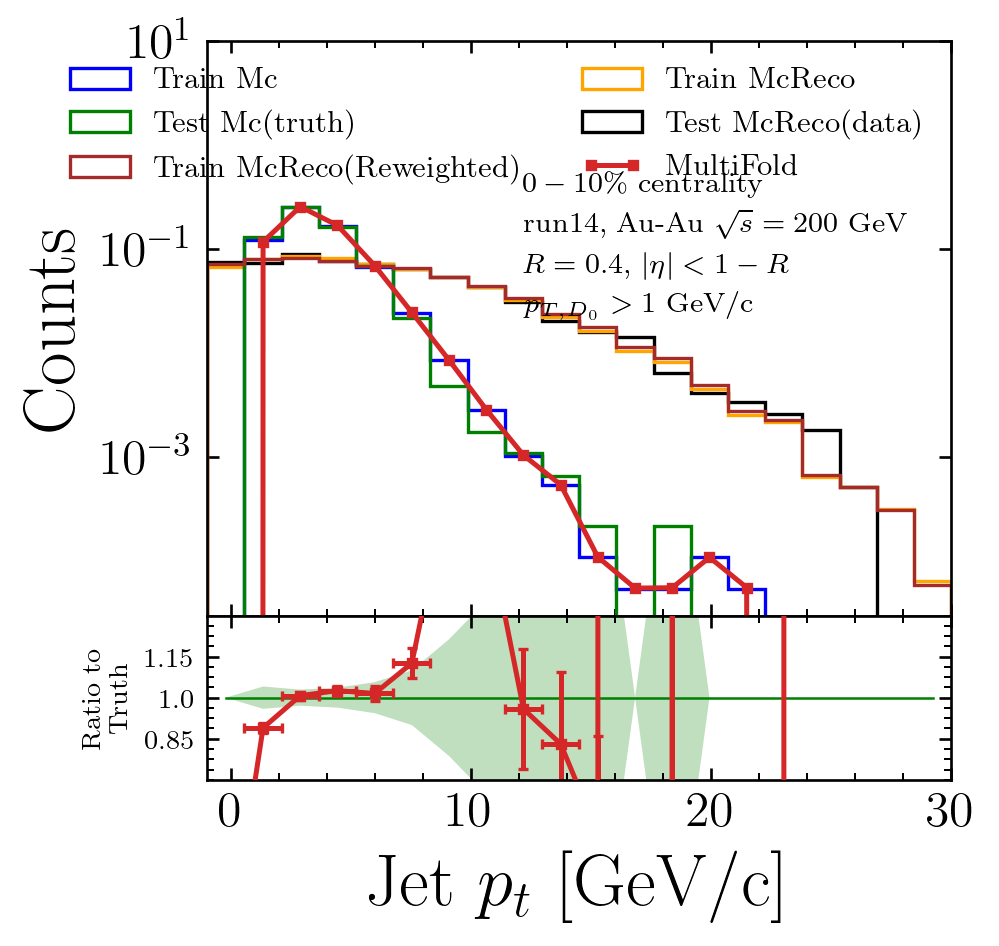

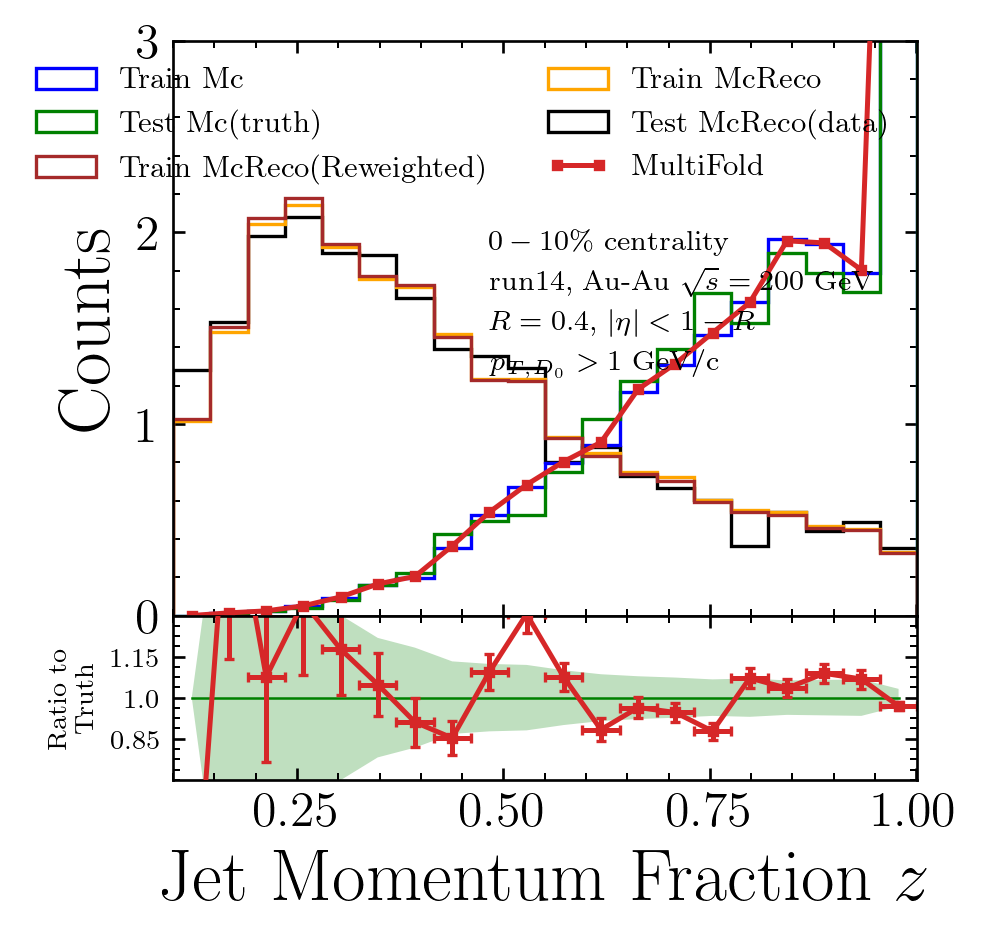

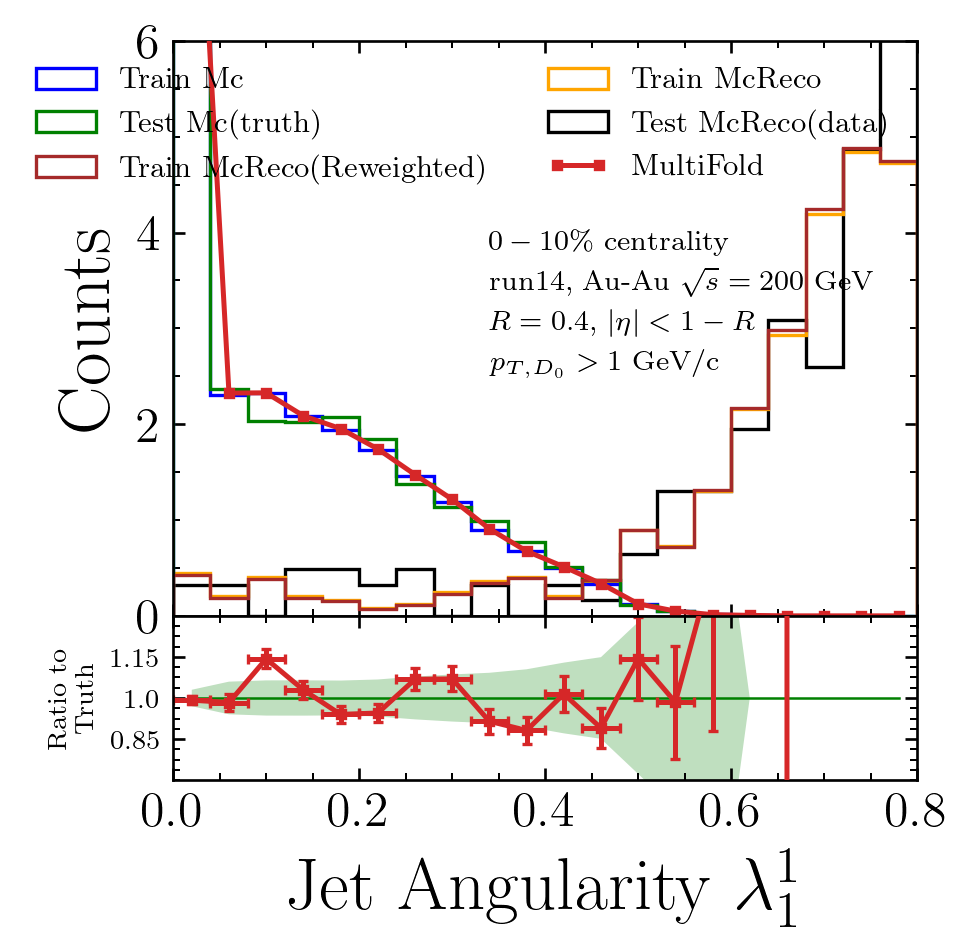

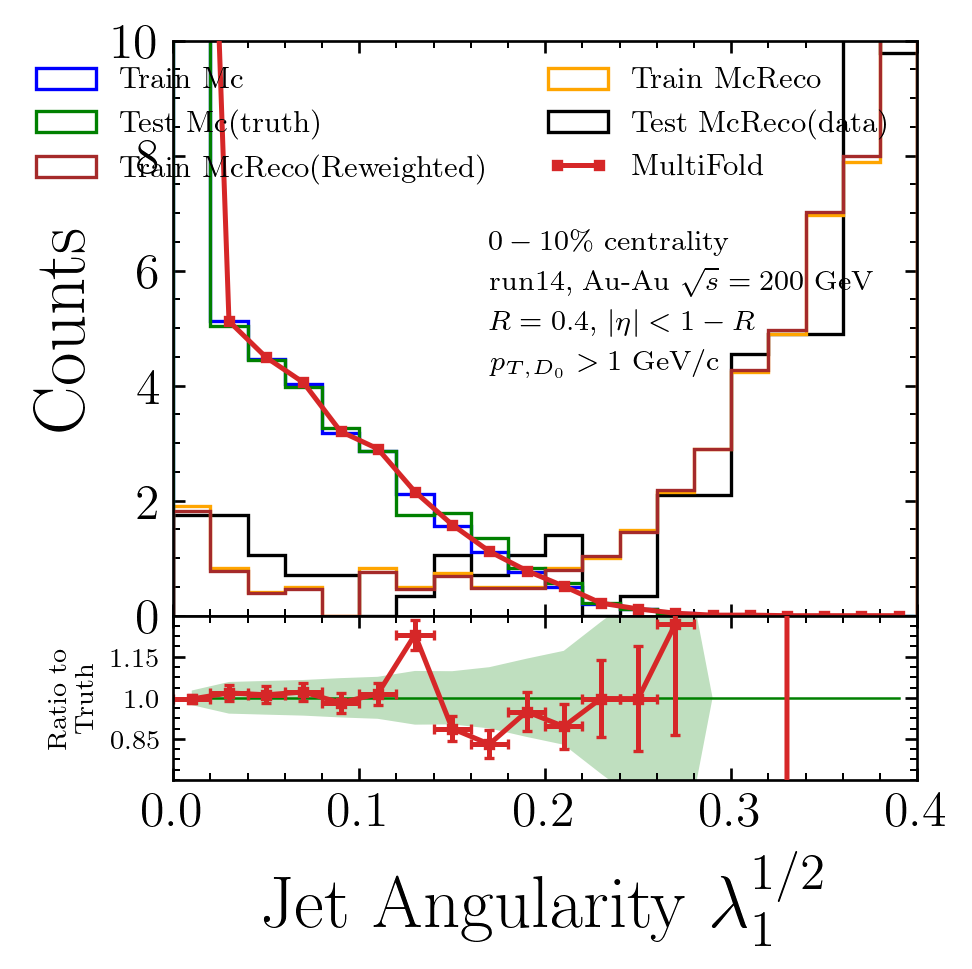

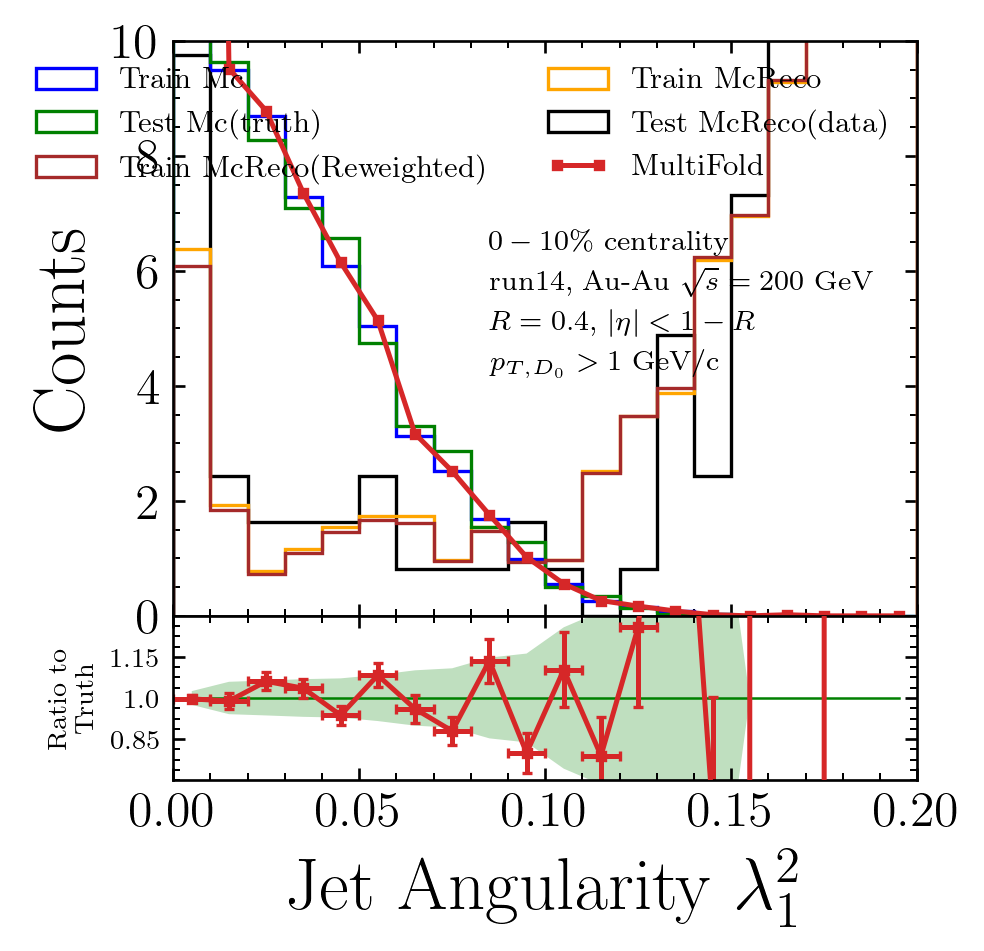

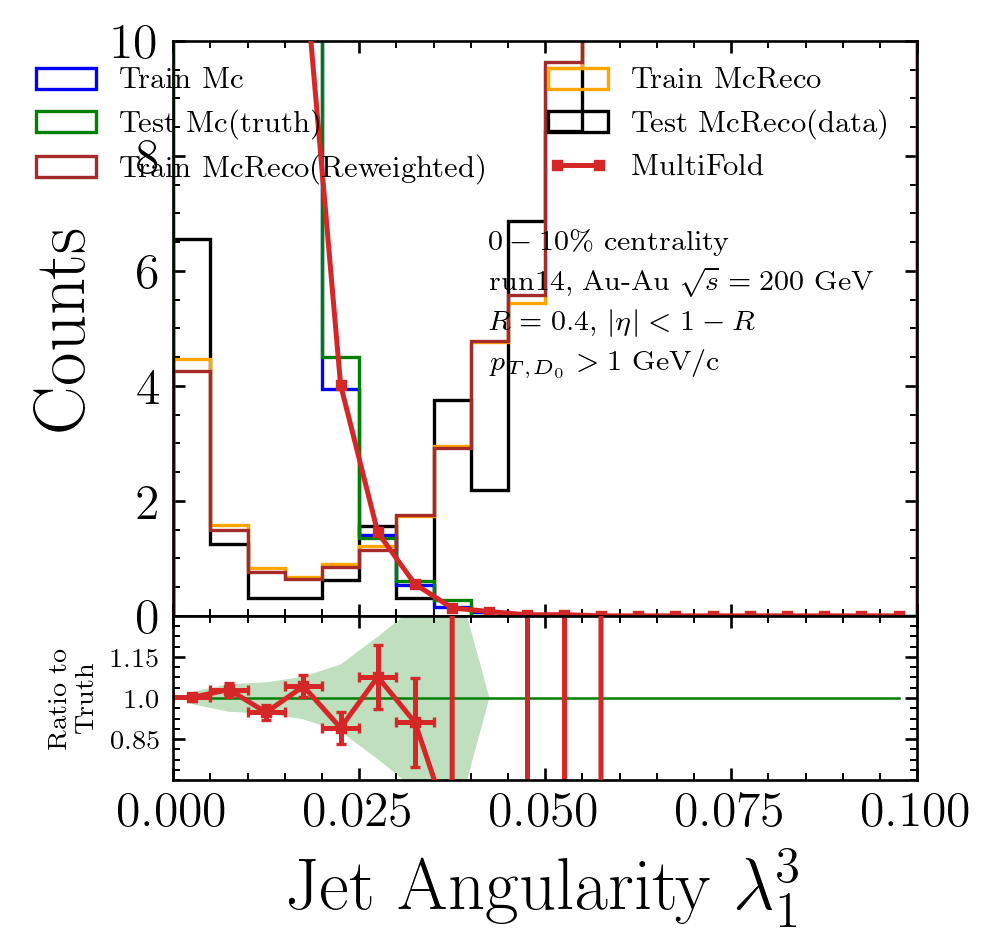

In [28]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 240
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})


# a dictionary to hold information about the observables
obs = {}
# the jet mass and histogram style information
obs.setdefault('pt', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (-1, 30),  'ylim': (0.00003, 10),
    'xlabel': r'Jet $p_{t}$  [GeV/c]', 'symbol': r'$p_{t}$',
    'ylabel': r'Counts', 'yscale': 'log',
    'stamp_xy': (0.425, 0.75),
})

# the groomed momentum fraction and histogram style information
obs.setdefault('z', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0.1, 1.001),   'ylim': (0, 3),
    'xlabel': r'Jet Momentum Fraction $z$', 'symbol': r'$z$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.8),  'ylim': (0, 6),
    'xlabel': r'Jet Angularity $\lambda_{1}^{1}$', 'symbol': r'$lambda_1_1$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1half', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.4),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 'symbol': r'$lambda_1_1half$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_2', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.2),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{2}$', 'symbol': r'$lambda_1_2$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_3', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.1),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{3}$', 'symbol': r'$lambda_1_3$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})


# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}


for obkey,ob in obs.items():
        # calculate observable for GEN, SIM, DATA
    ob['genobs'] = trainGen[obkey].to_numpy()
    ob['simobs'] = trainReco[obkey].to_numpy()

    ob['truthobs'] = testGen[obkey].to_numpy()
    ob['dataobs'] = testReco[obkey].to_numpy()

 # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]



    # get the histograms of GEN, DATA, and SIM level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'])[0]
    ob['simobs_hist'] = np.histogram(ob['simobs'], bins=ob['bins_det'])[0]
    ob['data_hist']   = np.histogram(ob['dataobs'], bins=ob['bins_det'])[0]
  
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
  
   
    print('Done with', obkey)


for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])


    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='Test McReco(data)', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Train McReco', **hist_style)

    ax0.hist(ob['genobs'], bins=ob['bins_mc'], color='blue', label='Train Mc', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['truthobs'], bins=ob['bins_mc'], color='green', label='Test Mc(truth)', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='brown', weights=weights[iterations-2,0,:], label='Train McReco(Reweighted)', **hist_style)

    # # # plot the "gen" histogram of the observable
    # ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # # plot the "truth" histogram of the observable
    # ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=weights[iterations-2,1,:], bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # Plot the Ratios of the OmniFold distribution to truth (with statistical uncertainties)

    of_ratio = of_histgen/(ob['truth_hist']+ 10**-50)
    ax1.plot(ob['midbins_mc'], of_ratio, **omnifold_style)

    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)

    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)

    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [2, 3, 4, 1, 0,5] 
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol,fontsize = 9)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.07, ax=ax0,
                  line_0=r'$0-10 \%$ centrality',
                  line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV',
                  line_2=r'$R=0.4$, $|\eta|<1-R$',
                  line_3=r'$p_{T,D_0}>1$ GeV/c')


    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')
    plt.show()
